## 找分布

In [1]:
from PIL import Image
import os

def get_image_size_range(folder_path):
    widths = []
    heights = []

    # 遞迴遍歷資料夾及其子資料夾
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(".jpg"):  # 可擴展支援更多格式
                img_path = os.path.join(root, file)
                try:
                    with Image.open(img_path) as img:
                        widths.append(img.width)
                        heights.append(img.height)
                except Exception as e:
                    print(f"無法讀取 {img_path}: {e}")

    if widths and heights:
        print(f"寬度範圍: {min(widths)} - {max(widths)} pixels")
        print(f"高度範圍: {min(heights)} - {max(heights)} pixels")
    else:
        print("沒有找到任何 .jpg 圖片")


# 指定你要掃描的資料夾
folder_path = "E:\\data_bone\\9-a+b_swift_cut_正確_V2\\front"
get_image_size_range(folder_path)

folder_path = "E:\\data_bone\\9-a+b_swift_cut_正確_V2\\side"
get_image_size_range(folder_path)

寬度範圍: 414 - 969 pixels
高度範圍: 649 - 1980 pixels
寬度範圍: 372 - 1209 pixels
高度範圍: 593 - 2159 pixels


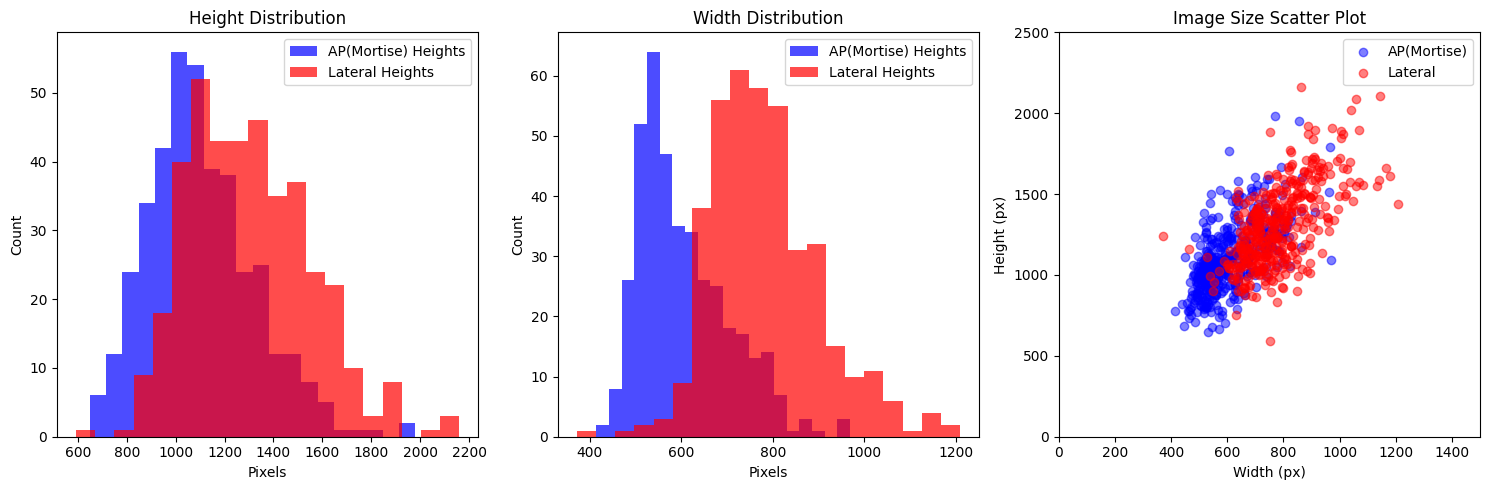

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def get_image_sizes(folder_path):
    widths, heights = [], []
    
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(".jpg"):  # 可擴展支援更多格式
                img_path = os.path.join(root, file)
                try:
                    with Image.open(img_path) as img:
                        widths.append(img.width)
                        heights.append(img.height)
                except Exception as e:
                    print(f"無法讀取 {img_path}: {e}")
    
    return widths, heights

def plot_image_sizes(folder_front, folder_side):
    widths_front, heights_front = get_image_sizes(folder_front)
    widths_side, heights_side = get_image_sizes(folder_side)
    
    if not widths_front or not heights_front or not widths_side or not heights_side:
        print("沒有找到任何 .jpg 圖片")
        return
    
    # 創建圖表
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 直方圖 - 前視圖與側視圖的高度分佈
    axes[0].hist(heights_front, bins=20, alpha=0.7, label='AP(Mortise) Heights', color='blue')
    axes[0].hist(heights_side, bins=20, alpha=0.7, label='Lateral Heights', color='red')
    axes[0].set_title('Height Distribution')
    axes[0].set_xlabel('Pixels')
    axes[0].set_ylabel('Count')
    axes[0].legend()

    # 直方圖 - 前視圖與側視圖的寬度分佈
    axes[1].hist(widths_front, bins=20, alpha=0.7, label='AP(Mortise) Heights', color='blue')
    axes[1].hist(widths_side, bins=20, alpha=0.7, label='Lateral Heights', color='red')
    axes[1].set_title('Width Distribution')
    axes[1].set_xlabel('Pixels')
    axes[1].set_ylabel('Count')
    axes[1].legend()
    
    # 散點圖 - todo: 從0開始畫
    axes[2].scatter(widths_front, heights_front, alpha=0.5, label='AP(Mortise)', color='blue')
    axes[2].scatter(widths_side, heights_side, alpha=0.5, label='Lateral', color='red')
    axes[2].set_title('Image Size Scatter Plot')
    axes[2].set_xlabel('Width (px)')
    axes[2].set_ylabel('Height (px)')
    axes[2].set_xlim(0, 1500)
    axes[2].set_ylim(0, 2500)
    axes[2].legend()
    plt.tight_layout()
    plt.show()

# 指定資料夾並繪圖
folder_front = "E:\\data_bone\\9-a+b_swift_cut_正確_V2\\front"
folder_side = "E:\\data_bone\\9-a+b_swift_cut_正確_V2\\side"

plot_image_sizes(folder_front, folder_side)


## model

In [4]:
# import
import numpy as np
import pandas as pd
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score
import os

# label
# =========================
def class_2_type(root):
    label = ""
    if "正常" in root:
        label = "0"
    else:
        label = "1"
    return label

def class_3_type(root):
    label = ""
    if "正常" in root:
        label = "0"
    elif "雙踝" in root:
        label = "1"
    elif "三踝" in root:
        label = "2"
    return label
# =========================

def load_path(path, class_count):
    dataset = []
    class_type = ''
    if class_count == 2:
        class_type = class_2_type
    elif class_count == 3:
        class_type = class_3_type   

    for root, dirs, files in os.walk(path):
        for file in files:
            label = class_type(root)
            if label != "":
                dataset.append(
                                {   
                                    'uuid': root.split("\\")[-1],
                                    'label': label,
                                    'image_path': os.path.join(root, file)
                                }
                            )

    return dataset


In [1]:
## 參數設置
image_dir = "E:\\data_bone\\9-a+b_swift_cut_正確_V2\\front"
concat_type = "spatial"
class_count = 3

In [2]:
## image spatail
# =========================
from PIL import Image
import os

def resize_and_merge_images(image_a_path, image_b_path, output_path):
    try:
        with Image.open(image_a_path) as img_a, Image.open(image_b_path) as img_b:
            img_a = img_a.resize((224, 224*2))
            img_b = img_b.resize((224, 224*2))
            
            merged_image = Image.new('RGB', (224*2, 224*2))
            
            merged_image.paste(img_a, (0, 0))
            merged_image.paste(img_b, (224, 0))
            
            merged_image.save(output_path)
    except Exception as e:
        print(f"Error processing images: {e}")

# Example usage
# a_image_path = "path/to/a_image.jpg"
# b_image_path = "path/to/b_image.jpg"
# output_image_path = "path/to/output.jpg"

# resize_and_merge_images(a_image_path, b_image_path, output_image_path)

# =========================

In [5]:
## load data and  labels
# =========================
data = load_path(image_dir, class_count)
labels = []
filepaths = []
for row in data:
    labels.append(row['label'])
    filepaths.append(row['image_path'])

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images_front = pd.concat([filepaths, labels], axis=1)
# =========================

## merge and save image
# =========================
images_side = images_front.copy()
images_side.loc[:, "Filepath"] = images_front["Filepath"].str.replace("front", "side")
images_side.loc[:, "Filepath"] = images_front["Filepath"].str.replace("front", "side")
for i in range(len(images_front)):
    resize_and_merge_images(images_front.loc[i]["Filepath"], images_side.loc[i]["Filepath"], images_front.loc[i]["Filepath"].replace("front", "spatial"))
# =========================

In [ ]:
## load spatial and split
image_dir2 = "E:\\data_bone\\9-a+b_swift_cut_正確_V2\\spatial"
data = load_path(image_dir2, class_count)
labels = []
filepaths = []
for row in data:
    labels.append(row['label'])
    filepaths.append(row['image_path'])

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images_spatial = pd.concat([filepaths, labels], axis=1)
train_df, test_df = train_test_split(images_spatial, train_size=0.8, shuffle=True, random_state=44, stratify=images_spatial['Label'])

print("Training set label distribution:\n", train_df['Label'].value_counts(normalize=False))
print("Test set label distribution:\n", test_df['Label'].value_counts(normalize=False))

# 關閉翻轉
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False,
                                                                    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                                                    validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
# =========================

In [ ]:

# load model
# =========================
pretrained_model = tf.keras.applications.resnet50.ResNet50(
    input_shape=(224*2, 224*2, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg')

pretrained_model.trainable = False

inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu', name='dense_128')(pretrained_model.output)
x = tf.keras.layers.Dense(50, activation='relu', name='dense_50')(x)

outputs = tf.keras.layers.Dense(class_count, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)
# print(model.summary())
# =========================

## 分資料
# =========================

# 確認
print(train_df.iloc[0]['Filepath'].split("\\")[-3])

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)
# =========================


## compile and evaluate
# =========================

print("-------Training " + "_" + concat_type + "-------")
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## early stop 
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# history=model.fit(train_images, validation_data=val_images, callbacks=[early_stopping], epochs=30)
## no early stop
history = model.fit(train_images, validation_data=val_images, epochs=30)

results = model.evaluate(test_images, verbose=0)
# =========================


## save model to this path
# =========================
model.save("./weights/"+concat_type+"_" + "_frac.h5")
# =========================


## print results
# =========================
# print(save_path + "_" + concat_type + "_Results:")
pred = model.predict(test_images)
predicted_labels = np.argmax(pred, axis=1)

# f1 = f1_score(test_images.labels, predicted_labels, average='macro')
# precision = precision_score(test_images.labels, predicted_labels, average='macro')
# recall = recall_score(test_images.labels, predicted_labels, average='macro')

# print(results)
# print(f"Test Accuracy: {np.round(results[1], 2)}")
# print(f"f1 score: {np.round(f1, 2)}")
# print(f"precision: {np.round(precision, 2)}")
# print(f"recall: {np.round(recall, 2)}")
# =========================


# create plots for accuracy and save it
# =========================
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
figAcc = plt.gcf()
my_file = os.path.join("./plots/"+concat_type+"_Accuracy.jpeg")
figAcc.savefig(my_file)
plt.clf()
# =========================


## create plots for loss and save it
# =========================
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
figAcc = plt.gcf()
my_file = os.path.join("./plots/"+concat_type+"_"+"_Loss.jpeg")
figAcc.savefig(my_file)
plt.clf()
# =========================


## plot confusion matrix
# =========================
if class_count == 2:
    display_labels = [0, 1]
elif class_count == 3:
    display_labels = [0, 1, 2]
elif class_count == 4:
    display_labels = [0, 1, 2, 3]


cm = confusion_matrix(test_images.labels, predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)
cm_display.plot()
plt.title('Confusion Matrix')
figAcc = plt.gcf()
my_file = os.path.join("./plots/"+concat_type+"_"+"_Confusion Matrix.jpeg")
figAcc.savefig(my_file)
plt.clf()
# =========================

In [ ]:
acc = accuracy_score(test_images.labels, predicted_labels)
f1 = f1_score(test_images.labels, predicted_labels, average='macro')
precision = precision_score(test_images.labels, predicted_labels, average='macro')
recall = recall_score(test_images.labels, predicted_labels, average='macro')

print(f"Test Accuracy: {np.round(acc, 2)}")
print(f"f1 score: {np.round(f1, 2)}")
print(f"precision: {np.round(precision, 2)}")
print(f"recall: {np.round(recall, 2)}")